<a href="https://colab.research.google.com/github/newbiepawel/Hello-Github/blob/master/predict_next_purchase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Installing the latest version of Tensorflow
!pip install tensorflow-gpu==2.0.0

In [4]:
# importing dependencies

from __future__ import absolute_import, division, print_function, unicode_literals

import warnings
warnings.filterwarnings('ignore')
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [5]:
# First look at the data
from google.colab import files
uploaded = files.upload()
df_raw = pd.read_csv('./retail_data.csv')
df_raw.head()

Saving retail_data.csv to retail_data (1).csv


InvoiceNo StockCode  ... CustomerID         Country
0          1    85123A  ...     5504.0  United Kingdom
1          1     71053  ...     5504.0  United Kingdom
2          1    84406B  ...     5504.0  United Kingdom
3          1    84029G  ...     5504.0  United Kingdom
4          1    84029E  ...     5504.0  United Kingdom

[5 rows x 8 columns]

In [6]:
# The dataset contains 541909 rows and 8 columns
df = df_raw.copy()
df.shape

(541909, 8)

In [0]:
# Class to create a report for Exploratory Data Analysis(EDA)

import sys
import warnings

from pandas_profiling.version import __version__
from pandas_profiling.utils.dataframe import clean_column_names, rename_index
from pandas_profiling.utils.paths import get_config_default, get_project_root

from pathlib import Path

from pandas_profiling.config import config
from pandas_profiling.controller import pandas_decorator
import pandas_profiling.view.templates as templates
from pandas_profiling.model.describe import describe as describe_df
from pandas_profiling.view.notebook import display_notebook_iframe
from pandas_profiling.view.report import to_html


class EDA(dataframe):
   

    html = ""
   

    def __init__(self, df, **kwargs):
        config.set_kwargs(kwargs)

    
        if (
            not pd.Index(np.arange(0, len(df))).equals(df.index)
            or df.index.dtype != np.int64
        ):
            df = df.reset_index()

        
        df = rename_index(df)

  
        df = clean_column_names(df)

       
        sort = config["sort"].get(str)
        if sys.version_info[1] <= 5 and sort != "None":
            warnings.warn("Sorting is supported from Python 3.6+")

        if sort in ["asc", "ascending"]:
            df = df.reindex(sorted(df.columns, key=lambda s: s.casefold()), axis=1)
        elif sort in ["desc", "descending"]:
            df = df.reindex(
                reversed(sorted(df.columns, key=lambda s: s.casefold())), axis=1
            )
        elif sort != "None":
            raise ValueError('"sort" should be "ascending", "descending" or None.')

        # Store column order
        config["column_order"] = df.columns.tolist()

        # Get dataset statistics
        description_set = describe_df(df)

        # Get sample
        sample = {}
        n_head = config["samples"]["head"].get(int)
        if n_head > 0:
            sample["head"] = df.head(n=n_head)

        n_tail = config["samples"]["tail"].get(int)
        if n_tail > 0:
            sample["tail"] = df.tail(n=n_tail)

        # Render HTML
        self.html = to_html(sample, description_set)
        self.minify_html = config["minify_html"].get(bool)
        self.use_local_assets = config["use_local_assets"].get(bool)
        self.title = config["title"].get(str)
        self.description_set = description_set
        self.sample = sample

    def get_description(self) -> dict:
     
        return self.description_set

    def get_rejected_variables(self, threshold: float = 0.9) -> list:
    
        variable_profile = self.description_set["variables"]
        result = []
        for col, values in variable_profile.items():
            if "correlation" in values:
                if values["correlation"] > threshold:
                    result.append(col)
        return result

    def to_file(self, output_file: Path or str, silent: bool = True) -> None:
       
        if type(output_file) == str:
            output_file = Path(output_file)

        with output_file.open("w", encoding="utf8") as f:
            wrapped_html = self.to_html()
            if self.minify_html:
                from htmlmin.main import minify

                wrapped_html = minify(
                    wrapped_html, remove_all_empty_space=True, remove_comments=True
                )
            f.write(wrapped_html)

        if not silent:
            import webbrowser

            webbrowser.open_new_tab(output_file)

    def to_html(self) -> str:
     
        return templates.template("wrapper.html").render(
            content=self.html,
            title=self.title,
            correlation=len(self.description_set["correlations"]) > 0,
            missing=len(self.description_set["missing"]) > 0,
            sample=len(self.sample) > 0,
            version=__version__,
            offline=self.use_local_assets,
            primary_color=config["style"]["primary_color"].get(str),
            theme=config["style"]["theme"].get(str),
        )

    def get_unique_file_name(self):
      
        return (
            "profile_"
            + str(np.random.randint(1000000000, 9999999999, dtype=np.int64))
            + ".html"
        )

    def _repr_html_(self):
 
        display_notebook_iframe(self)

    def __repr__(self):
        
        return ""

In [0]:
# Based on the below report:
# There is 38 Distinc countries where most of the transactions coming from UK
# 4373 Unique customers, but there are 24.9% of the values are missing
# Costumers bought the most "WHITE HANGING HEART T-LIGHT HOLDER", "REGENCY CAKESTAND 3 TIER",
# "JUMBO BAG RED RETROSPOT" respectively, there is 0.3% missing values
# 23260 distinct dates of transaction, where the most transactions were generated on 2011-10-31 14:41:00 (1114)
# 25900 unique transactions
# Customers on average bought 9.5 pieces of the product
# 4070 unique products
# Average product price is around 4.6

# Thanks to the report some issues could been identified like min quantity is -80995 or min Unit Price is -11062.06
# or maximum price per unit 38970 which sounds suspicious. Those issues must be investigated and data need to be cleaned

EDA(df)

# DATA CLEANING AND ENGINEERING:

### Country:

In [5]:
print("{}{}{}{}".format(np.round((len(df[df['Country'] == 'United Kingdom'])/len(df))*100, 2),'%',' ',
                        'of the whole records coming from UK'))

91.43% of the whole records coming from UK


In [6]:
# On more look at the dsitribution of Countries in respect to number of rows
df[['Country', 'InvoiceNo']].groupby('Country').count().sort_values(by='InvoiceNo', ascending=False)

InvoiceNo
Country                        
United Kingdom           495478
Germany                    9495
France                     8557
EIRE                       8196
Spain                      2533
Netherlands                2371
Belgium                    2069
Switzerland                2002
Portugal                   1519
Australia                  1259
Norway                     1086
Italy                       803
Channel Islands             758
Finland                     695
Cyprus                      622
Sweden                      462
Unspecified                 446
Austria                     401
Denmark                     389
Japan                       358
Poland                      341
Israel                      297
USA                         291
Hong Kong                   288
Singapore                   229
Iceland                     182
Canada                      151
Greece                      146
Malta                       127
United Arab Emirates         68
European Community           61
RSA                          58
Lebanon                      45
Lithuania                    35
Brazil                       32
Czech Republic               30
Bahrain                      19
Saudi Arabia                 10

In [7]:
# Distribution of the Countries in respect to unique transactions
a = df.groupby('Country')['InvoiceNo'].nunique()
a = pd.DataFrame(a)
a.sort_values(by = 'InvoiceNo', ascending = False)

InvoiceNo
Country                        
United Kingdom            23494
Germany                     603
France                      461
EIRE                        360
Belgium                     119
Spain                       105
Netherlands                 101
Switzerland                  74
Portugal                     71
Australia                    69
Italy                        55
Finland                      48
Sweden                       46
Norway                       40
Channel Islands              33
Japan                        28
Poland                       24
Denmark                      21
Cyprus                       20
Austria                      19
Hong Kong                    15
Unspecified                  13
Malta                        10
Singapore                    10
Israel                        9
Iceland                       7
USA                           7
Greece                        6
Canada                        6
Czech Republic                5
European Community            5
Lithuania                     4
Bahrain                       4
United Arab Emirates          3
Saudi Arabia                  2
Lebanon                       1
RSA                           1
Brazil                        1

In [8]:
# Once more:
print("{}{}{}{}{}".format(np.round((len(df[df['Country'] == 'United Kingdom'])/len(df))*100, 2),'%',' ',
                        'of the whole records coming from UK but', ','))
a.reset_index(level='Country', inplace=True)
print("{}{}{}{}".format(np.round((a['InvoiceNo'][a['Country'] == 'United Kingdom'].sum()/a['InvoiceNo'].sum()*100), 2),
                        '%', ' ', 'of the whole uniques transactions coming from UK'))

91.43% of the whole records coming from UK but,
90.71% of the whole uniques transactions coming from UK


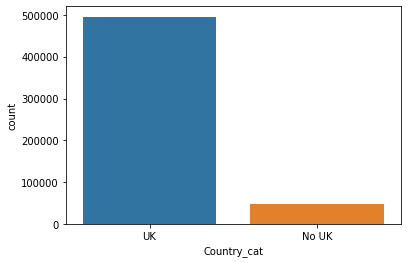

In [9]:
# Here is the visual representation of the above
# It seems reasonable for me to create a new veriable where if the Country is "United Kingdom" then 1 otherwise 0
# instead of split all countries into different columns
# i think it's a proper decision due to it's better if the data feeding model have less dimensions
df['Country_cat'] = df['Country']
df['Country_cat'][df['Country_cat'] != 'United Kingdom'] = 'No UK'
df['Country_cat'][df['Country_cat'] == 'United Kingdom'] = 'UK'

sns.countplot( x = 'Country_cat', data = df,orient = 'v')

In [10]:
df['Country_cat'].value_counts()

UK       495478
No UK     46431
Name: Country_cat, dtype: int64

### CustomerID:

In [11]:
# Number of unique customers
df['CustomerID'].nunique()

4372

In [12]:
# There are some missing values but it's not a big deal as the task
# is to predict when the product will be bought again
df['CustomerID'].isna().sum()

135080

### Description:

In [12]:
# There is 4223 unique product names in the dataset
df['Description'].nunique()

4223

In [13]:
# There is also so missing values but We can rely on "StockCode" variable
# as it represents unique code for every product and there is no missing values
df['Description'].isna().sum()

1454

### InvoiceDate:

In [14]:
print('The time range of the data is from',df['InvoiceDate'].min(), 'to',  df['InvoiceDate'].max())

The time range of the data is from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [15]:
type(df['InvoiceDate'])

pandas.core.series.Series

In [16]:
#There are 305 unique days when transaction has been made
pd.to_datetime(df['InvoiceDate']).dt.date.value_counts().count()

305

In [0]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [19]:
df.head()

InvoiceNo StockCode  ...         Country  Country_cat
0          1    85123A  ...  United Kingdom           UK
1          1     71053  ...  United Kingdom           UK
2          1    84406B  ...  United Kingdom           UK
3          1    84029G  ...  United Kingdom           UK
4          1    84029E  ...  United Kingdom           UK

[5 rows x 9 columns]

In [18]:
# No missing values
df['InvoiceDate'].isna().sum()

0

In [19]:
# Here is the look at the Stock code with the calculated time interval(in sec) from the last order
# Negative time intervals have been set to -1
df.sort_values(['StockCode','InvoiceDate']).groupby('StockCode').InvoiceDate\
.diff()\
.apply(lambda x: x.seconds if x >= pd.Timedelta(0) else -1.0).head()

31         -1.0
142      3600.0
4272    16680.0
5466    75360.0
5546      540.0
Name: InvoiceDate, dtype: float64

In [20]:
# I decided to create a variable with this time interval
# I decided to do this through StockCode as there are missing values in "Description"
# I think it's usefull when predicting when the product will be bought next time
# first orders are set to NaN
df['time_from_last_order'] =\
  df.sort_values(['StockCode','InvoiceDate']).groupby('StockCode').InvoiceDate\
  .diff()\
  .apply(lambda x: x.seconds if x >= pd.Timedelta(0) else -1.0)
df.sample(5)

InvoiceNo StockCode  ... Country_cat  time_from_last_order
491924      41716     23333  ...          UK                1320.0
3123          236    82494L  ...          UK               55560.0
192322      17039     23284  ...          UK               59100.0
281100      25149     22489  ...          UK                3060.0
186659      16513     22898  ...          UK               67260.0

[5 rows x 10 columns]

In [21]:
# Looking how it looks like with the example of "71053" StockCode
# Time intervals are in sec.
df[['StockCode', 'InvoiceDate', 'time_from_last_order']][df['StockCode'] == '22494'].head()

StockCode         InvoiceDate  time_from_last_order
1307      22494 2010-12-01 13:24:00                  -1.0
1592      22494 2010-12-01 14:32:00                4080.0
2194      22494 2010-12-01 15:35:00                3780.0
8521      22494 2010-12-05 12:43:00               76080.0
10533     22494 2010-12-06 09:58:00               76500.0

In [22]:
# I think that it could be also reasonable if I add a variable which represents the day of the week
# I guess there is more traffic in some days and customers buy more product
df['day'] = df['InvoiceDate'].dt.dayofweek
df.head()

InvoiceNo StockCode  ... time_from_last_order  day
0          1    85123A  ...                 -1.0    2
1          1     71053  ...                 -1.0    2
2          1    84406B  ...                 -1.0    2
3          1    84029G  ...                 -1.0    2
4          1    84029E  ...                 -1.0    2

[5 rows x 11 columns]

### InvoiceNo:


In [23]:
# Now in the dataset is 25900 unique transactions
df['InvoiceNo'].nunique()

25900

In [24]:
# No missing values
df['InvoiceNo'].isnull().sum()

0

### Quantity:

In [25]:
# There is over 10000 records where Quantity is with sign "-".
# Maybe the custumer was disappointed by the product and got a refund or it's an error.
# Needs to be investigated
print('number of records where quantity lower than zero:', df['Quantity'][df['Quantity'] < 0].count())
df[df['Quantity'] < 0].head()

number of records where quantity lower than zero: 10624


InvoiceNo StockCode  ... time_from_last_order  day
141         15         D  ...                 -1.0    2
154         19    35004C  ...                 -1.0    2
235         27     22556  ...                 -1.0    2
236         27     21984  ...                 -1.0    2
237         27     21983  ...                 -1.0    2

[5 rows x 11 columns]

In [26]:
# Taking one StockCode which is with "-" 
# As could be grasped below a product it's not an issue here and it does not look like it's a refund
# At least from time range of the dataset
# Taking the example of "35004C" StockCode
df[df['StockCode'] =='35004C']

InvoiceNo StockCode  ... time_from_last_order  day
154            19    35004C  ...                 -1.0    2
200            25    35004C  ...                840.0    2
297            33    35004C  ...               2880.0    2
2316          212    35004C  ...              19200.0    2
3933          375    35004C  ...              75420.0    3
6544          583    35004C  ...              84060.0    4
7417          672    35004C  ...              17940.0    4
9200          831    35004C  ...              73620.0    6
17311        1336    35004C  ...              75360.0    2
17451        1398    35004C  ...               4200.0    2
18196        1441    35004C  ...               4620.0    2
22328        1799    35004C  ...              14940.0    3
24005        1943    35004C  ...              72000.0    4
25245        1999    35004C  ...              13620.0    4
28630        2287    35004C  ...              78780.0    0
30476        2502    35004C  ...              84780.0    1
32355        2689    35004C  ...               6720.0    2
32787        2780    35004C  ...              68640.0    3
32955        2848    35004C  ...               2640.0    3
33842        2935    35004C  ...              18600.0    3
34430        3010    35004C  ...              65400.0    4
39381        3276    35004C  ...              13620.0    0
41696        3592    35004C  ...              77280.0    3
43501        3729    35004C  ...               8940.0    1
44157        3793    35004C  ...              73020.0    2
45586        3904    35004C  ...              85440.0    3
52295        4338    35004C  ...              81180.0    1
54224        4542    35004C  ...               6780.0    2
57232        4772    35004C  ...              82080.0    4
57584        4850    35004C  ...              10920.0    4
59542        4929    35004C  ...              86280.0    0
63115        5157    35004C  ...              72360.0    2
67605        5477    35004C  ...               7680.0    6
69226        5604    35004C  ...               6240.0    0
73600        6002    35004C  ...              83820.0    3
74264        6048    35004C  ...              14100.0    3
76680        6274    35004C  ...              66360.0    0
78333        6502    35004C  ...               3540.0    1
80303        6671    35004C  ...              13020.0    2
81778        6809    35004C  ...              63540.0    4
82300        6833    35004C  ...              11160.0    4
83877        6991    35004C  ...               4440.0    0
86292        7179    35004C  ...               6180.0    2
86470        7183    35004C  ...               5040.0    2
86839        7239    35004C  ...              74580.0    3
91071        7721    35004C  ...              11340.0    1
110500       9324    35004C  ...              71580.0    6
112074       9504    35004C  ...               6660.0    0
171721      15083    35004C  ...               5160.0    3

[49 rows x 11 columns]

In [27]:
# It looks like it's an error or refund regarding to purchase made before the time range of the data.
# Nevertheless customer made a purchase later on
# Those records can be removed as the task is to predict when the next purchase will take place,
# but it's not a purchase, maybe refund or an error
# Based on example from the first row of previous frame,
# there is no purchase with "Quantity" of 1 and "UnitPrice" of 4.65
df[(df['CustomerID'] == 2965.0) & (df['Quantity'] == 1) & (df['UnitPrice'] == 4.65)]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Country_cat, time_from_last_order, day]
Index: []

In [28]:
# but first checking if there is Quantity = 0
df['Quantity'][df["Quantity"] == 0].count()

0

In [0]:
# Removing records with "-" Quantities
df = df[df['Quantity'] > 0]

In [30]:
df.shape

(531285, 11)

In [31]:
# No more transactions with "-" transactions
df[df['Quantity'] < 0]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Country_cat, time_from_last_order, day]
Index: []

In [32]:
# Look at the first rows with the highest amount purchased by a single transaction
df.nlargest(10, 'Quantity')

InvoiceNo StockCode  ... time_from_last_order  day
540421      45119     23843  ...                 -1.0    4
61619        5067     23166  ...                 -1.0    1
502122      42477     84826  ...              17160.0    4
74614        6140     37413  ...                 -1.0    4
421632      36644     84077  ...               7200.0    3
206121      18504     22197  ...              77460.0    4
220843      19867    85123A  ...               6480.0    3
97432        8248     22053  ...              75000.0    1
270885      24235     18007  ...              14580.0    1
52711        4451     21108  ...               1500.0    1

[10 rows x 11 columns]

In [33]:
# Customers most often bought one product
np.round(df['Quantity'].mode(), 3)

0    1
dtype: int64

In [0]:
# importing needed library to check kurtosis
from scipy.stats import kurtosis, skew

In [35]:
# Kurtosis is enormous which means the data are very cocnentrated
kurtosis(df['Quantity'])

228251.69317928806

In [36]:
skew(df['Quantity'])

460.12966825725385

### StockCode:

In [37]:
# Now there is 3941 unique products in the dataset
df['StockCode'].nunique()

3941

In [38]:
# No missing values
df['StockCode'].isna().sum()

0

In [39]:
# Here are the most occuring product: WHITE HANGING HEART T-LIGHT HOLDER 
df['frequency'] = df.groupby('StockCode')['StockCode'].transform('count')
df[['StockCode', 'frequency', 'Description']].sort_values(by= 'frequency', ascending=False).head()

StockCode  frequency                         Description
0         85123A       2270  WHITE HANGING HEART T-LIGHT HOLDER
272845    85123A       2270  WHITE HANGING HEART T-LIGHT HOLDER
269074    85123A       2270  WHITE HANGING HEART T-LIGHT HOLDER
269854    85123A       2270  WHITE HANGING HEART T-LIGHT HOLDER
2408      85123A       2270  WHITE HANGING HEART T-LIGHT HOLDER

In [40]:
# Now looking at top 5
df['frequency'] = df.groupby('StockCode')['StockCode'].transform('count')
df.head()

InvoiceNo StockCode  ... day  frequency
0          1    85123A  ...   2       2270
1          1     71053  ...   2        346
2          1    84406B  ...   2        287
3          1    84029G  ...   2        470
4          1    84029E  ...   2        444

[5 rows x 12 columns]

### UnitPrice:

In [41]:
# There are records with price below zero, it seems to be an error or refund
print('number of records where price lower than zero:', df['UnitPrice'][df['UnitPrice'] < 0].count())
df[df['UnitPrice'] < 0]

number of records where price lower than zero: 2


InvoiceNo StockCode  ... day  frequency
299983      26822         B  ...   4          3
299984      26823         B  ...   4          3

[2 rows x 12 columns]

In [0]:
# As the task is to predict when the next product will be bought again, 
# I decided to remove those two records due to (most probably) an error or refund is not a purchase

In [0]:
# Removing records with the price below zero
df.drop([299983	, 299984], axis = 0, inplace=True)

In [43]:
# No more records with negative price
print('number of records where price lower than zero:', df['UnitPrice'][df['UnitPrice'] < 0].count())
df[df['UnitPrice'] < 0]

number of records where price lower than zero: 0


Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Country_cat, time_from_last_order, day, frequency]
Index: []

In [44]:
# There are also records with the price equal to zero, it must be investigated
df[df['UnitPrice'] == 0].count()

InvoiceNo               1179
StockCode               1179
Description              587
Quantity                1179
InvoiceDate             1179
UnitPrice               1179
CustomerID                40
Country                 1179
Country_cat             1179
time_from_last_order    1179
day                     1179
frequency               1179
dtype: int64

In [45]:
# It looks like it's an error or a client had a voucher or some kind of discount,
# but first checking if this is the real price of the product
df[df['UnitPrice'] == 0].head()

InvoiceNo StockCode Description  ...  time_from_last_order day  frequency
622          50     22139         NaN  ...                7860.0   2        976
1970        181     21134         NaN  ...                  -1.0   2          1
1971        182     22145         NaN  ...                  -1.0   2          3
1972        183     37509         NaN  ...                  -1.0   2          4
1987        185    85226A         NaN  ...                  -1.0   2          1

[5 rows x 12 columns]

In [46]:
# Checking the first product from the frame above
# The price is not 0, nevertheless I decided to not drop those records as it could be bought with a voucher
# and the task is to predict when the product gonna be bought again.
df[df['StockCode'] == '22841'].head()

InvoiceNo StockCode  ... day  frequency
2834        228     22841  ...   2        215
3925        374     22841  ...   3        215
5111        480     22841  ...   3        215
5328        495     22841  ...   4        215
9302        833     22841  ...   6        215

[5 rows x 12 columns]

In [47]:
# The most expensive product is worth 13541.33
# I wonder what is that
df['UnitPrice'].max()

13541.33

In [48]:
df[df['UnitPrice'] == 13541.33]

InvoiceNo  StockCode Description  ...  time_from_last_order day  frequency
15017       1268  AMAZONFEE  AMAZON FEE  ...                 240.0   1          2

[1 rows x 12 columns]

In [49]:
# Kurtosis is also outstanding what explains the distribution of the data 
kurtosis(df['UnitPrice'])

62618.43637729905

In [50]:
# Skew is right skewed which seems reasonable
skew(df['UnitPrice'])

206.30861559338365

In [0]:
#######################################################################################################################

### Other features:

In [51]:
df.shape

(531283, 12)

In [52]:
df.head()

InvoiceNo StockCode  ... day  frequency
0          1    85123A  ...   2       2270
1          1     71053  ...   2        346
2          1    84406B  ...   2        287
3          1    84029G  ...   2        470
4          1    84029E  ...   2        444

[5 rows x 12 columns]

In [53]:
# I also decided to create some more feature which could improve the performance of the model
# it is time between the orders of the item, This is to capture dynamicity of orders per product
# I decided that the most convinient would be 3 previous orders
# Missinga values are set to -1 to mark the first time orders


df['time_from_last_order_t-1'] = df.sort_values(['StockCode','InvoiceDate']).groupby('StockCode').time_from_last_order.shift(1).apply(lambda x: x if x >= 0 else -1.0)
df['time_from_last_order_t-2'] = df.sort_values(['StockCode','InvoiceDate']).groupby('StockCode').time_from_last_order.shift(2).apply(lambda x: x if x >= 0 else -1.0)
df['time_from_last_order_t-3'] = df.sort_values(['StockCode','InvoiceDate']).groupby('StockCode').time_from_last_order.shift(3).apply(lambda x: x if x >= 0 else -1.0)

# The below variables could be created representing the time to next order in sec, but
# it would be like cheating as I am to predict when next purchase of the product occur

#df['next_order'] = df.sort_values(['StockCode','InvoiceDate']).groupby('StockCode').time_from_last_order.shift(-1).apply(lambda x: x if x >= 0 else np.nan)
#df['next_order_t+2'] = df.sort_values(['StockCode','InvoiceDate']).groupby('StockCode').time_from_last_order.shift(-2).apply(lambda x: x if x >= 0 else np.nan)
#df['next_order_t+3'] = df.sort_values(['StockCode','InvoiceDate']).groupby('StockCode').time_from_last_order.shift(-3).apply(lambda x: x if x >= 0 else np.nan)
df.sample(5)

InvoiceNo StockCode  ... time_from_last_order_t-2  time_from_last_order_t-3
128559      10993     22138  ...                   2040.0                    2820.0
42793        3657     20655  ...                   3480.0                     480.0
188832      16699     22084  ...                   4560.0                    3900.0
348329      31060     21974  ...                  73500.0                   83040.0
91235        7725     22135  ...                   8580.0                   83340.0

[5 rows x 15 columns]

In [54]:
# Checking if was counted correctly on the example of StockCode 21754.
# Seems to look correctly
df[df['StockCode'] == '23209']

InvoiceNo StockCode  ... time_from_last_order_t-2  time_from_last_order_t-3
177880      15823     23209  ...                     -1.0                      -1.0
179020      15893     23209  ...                     -1.0                      -1.0
179047      15895     23209  ...                     -1.0                      -1.0
179068      15897     23209  ...                  76140.0                      -1.0
179135      15899     23209  ...                    300.0                   76140.0
...           ...       ...  ...                      ...                       ...
536269      44855     23209  ...                   1080.0                    5460.0
538583      45046     23209  ...                  58500.0                    1080.0
538880      45056     23209  ...                    480.0                   58500.0
539795      45075     23209  ...                  14400.0                     480.0
539923      45086     23209  ...                   3300.0                   14400.0

[1124 rows x 15 columns]

In [55]:
# I decided to add some more features to feed our model which can improve the performance
# There are some statistics of time between the orders of the given product
stats = df.groupby('StockCode').time_from_last_order.max().to_frame()
stats.columns = ['time_from_last_order_max']
stats['time_from_last_order_min'] = df.groupby('StockCode').time_from_last_order.agg([lambda x: x[x >= 0].min()])
stats['time_from_last_order_median'] = df.groupby('StockCode').time_from_last_order.agg([lambda x: x[x >= 0].median()])
stats['time_from_last_order_mean'] = df.groupby('StockCode').time_from_last_order.agg([lambda x: x[x >= 0].mean()])
stats.fillna(-1.0,inplace=True)
stats.reset_index(inplace=True)
df = df.merge(stats, on='StockCode', how='left', copy=False)
df.sample(5)

InvoiceNo  ... time_from_last_order_mean
215444      19754  ...              34696.397516
6087          512  ...              29708.918919
38592        3269  ...              22764.965894
522945      44659  ...              32109.056604
469989      40811  ...              14405.253078

[5 rows x 19 columns]

In [56]:
# Creating the dependent variable:
df['next_order'] = df.sort_values(['StockCode','InvoiceDate']).groupby('StockCode').time_from_last_order.shift(-1).apply(lambda x: x if x >= 0 else -1.0)
# Last orders also are set to zero
df.sample(5)

InvoiceNo StockCode  ... time_from_last_order_mean  next_order
122569      10657     22499  ...              26959.951100       660.0
132061      11503     21078  ...              30865.930599     85800.0
511038      44002     22835  ...              20667.321429        60.0
233938      21599     22771  ...              31430.198675     20160.0
524467      44816     23497  ...              14220.000000     62880.0

[5 rows x 20 columns]

In [57]:
# Checking if all was calculated correctly by taking a sample
# Looks correct
df[df['StockCode'] == '20725']

InvoiceNo StockCode  ... time_from_last_order_mean  next_order
93             14     20725  ...              15025.633626      6240.0
359            37     20725  ...              15025.633626      1680.0
605            48     20725  ...              15025.633626      9780.0
1857          180     20725  ...              15025.633626      6060.0
2299          213     20725  ...              15025.633626      3180.0
...           ...       ...  ...                       ...         ...
528786      45075     20725  ...              15025.633626      5040.0
529321      45086     20725  ...              15025.633626     58140.0
530141      45128     20725  ...              15025.633626      5460.0
531073      45174     20725  ...              15025.633626      2940.0
531239      45219     20725  ...              15025.633626        -1.0

[1595 rows x 20 columns]

# CREATING THE MODEL:

In [79]:
df.shape

(531283, 20)

In [80]:
df.isna().sum()

InvoiceNo                           0
StockCode                           0
Description                       592
Quantity                            0
InvoiceDate                         0
UnitPrice                           0
CustomerID                     133359
Country                             0
Country_cat                         0
time_from_last_order                0
day                                 0
frequency                           0
time_from_last_order_t-1            0
time_from_last_order_t-2            0
time_from_last_order_t-3            0
time_from_last_order_max            0
time_from_last_order_min            0
time_from_last_order_median         0
time_from_last_order_mean           0
next_order                          0
dtype: int64

In [81]:
df.head()

InvoiceNo StockCode  ... time_from_last_order_mean  next_order
0          1    85123A  ...              11262.309387      2160.0
1          1     71053  ...              32573.739130      2160.0
2          1    84406B  ...              33584.265734      2160.0
3          1    84029G  ...              24852.153518      2160.0
4          1    84029E  ...              21384.785553      2160.0

[5 rows x 20 columns]

In [58]:
# Defining dependent and independent variables
X_ = df.drop(['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'CustomerID', 'Country', 'next_order'], axis = 1)
y_ = df['next_order']
print('Shape of independent and dependent variables is respectively:', X_.shape, ',', y_.shape)
print('variables into X:', X_.keys(), '\n', 'y variable:','next_order')

Shape of independent and dependent variables is respectively: (531283, 13) , (531283,)
variables into X: Index(['Quantity', 'UnitPrice', 'Country_cat', 'time_from_last_order', 'day',
       'frequency', 'time_from_last_order_t-1', 'time_from_last_order_t-2',
       'time_from_last_order_t-3', 'time_from_last_order_max',
       'time_from_last_order_min', 'time_from_last_order_median',
       'time_from_last_order_mean'],
      dtype='object') 
 y variable: next_order


In [59]:
X_.head()

Quantity  UnitPrice  ... time_from_last_order_median  time_from_last_order_mean
0         6       2.55  ...                      2640.0               11262.309387
1         6       3.39  ...                     11340.0               32573.739130
2         8       2.75  ...                     13110.0               33584.265734
3         6       3.39  ...                      6480.0               24852.153518
4         6       3.39  ...                      5400.0               21384.785553

[5 rows x 13 columns]

In [0]:
# Of course the model cannot be fitted with the data like this,
# data need to be standarized to have an equal impact on the model binarized.

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [61]:
# Creating separate column for every day of the "day" variable
df_dummy = pd.get_dummies(X_['day'])
df_dummy.head()

0  1  2  3  4  6
0  0  0  1  0  0  0
1  0  0  1  0  0  0
2  0  0  1  0  0  0
3  0  0  1  0  0  0
4  0  0  1  0  0  0

In [62]:
# Concatenating with the X
X_ = pd.concat([X_,df_dummy], axis=1)
X_.head()

Quantity  UnitPrice Country_cat  time_from_last_order  day  ...  1  2  3  4  6
0         6       2.55          UK                  -1.0    2  ...  0  1  0  0  0
1         6       3.39          UK                  -1.0    2  ...  0  1  0  0  0
2         8       2.75          UK                  -1.0    2  ...  0  1  0  0  0
3         6       3.39          UK                  -1.0    2  ...  0  1  0  0  0
4         6       3.39          UK                  -1.0    2  ...  0  1  0  0  0

[5 rows x 19 columns]

In [87]:
df['Country_cat'].value_counts()

UK       486284
No UK     44999
Name: Country_cat, dtype: int64

In [63]:
# Binarizing "Country_cat" variable
dic = {'UK':1, 'No UK':0}
X_['Country_cat'] = X_['Country_cat'].map(dic)
X_.head()

Quantity  UnitPrice  Country_cat  time_from_last_order  day  ...  1  2  3  4  6
0         6       2.55            1                  -1.0    2  ...  0  1  0  0  0
1         6       3.39            1                  -1.0    2  ...  0  1  0  0  0
2         8       2.75            1                  -1.0    2  ...  0  1  0  0  0
3         6       3.39            1                  -1.0    2  ...  0  1  0  0  0
4         6       3.39            1                  -1.0    2  ...  0  1  0  0  0

[5 rows x 19 columns]

In [243]:
print('Final shape of the X:', X_.shape)
print('\n')
print('variables into X:', X_.keys())

Final shape of the X: (531283, 19)


variables into X: Index([                   'Quantity',                   'UnitPrice',
                       'Country_cat',        'time_from_last_order',
                               'day',                   'frequency',
          'time_from_last_order_t-1',    'time_from_last_order_t-2',
          'time_from_last_order_t-3',    'time_from_last_order_max',
          'time_from_last_order_min', 'time_from_last_order_median',
         'time_from_last_order_mean',                             0,
                                   1,                             2,
                                   3,                             4,
                                   6],
      dtype='object')


In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [0]:
# Standarize the X
X = sc.fit_transform(X_)

In [0]:
# making the all data of the same type
X = X_.values
y = y_.values

In [66]:
# Splitting into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
print('','X_train shape:', X_train.shape, '\n',
      'y_train shape:', y_train.shape, '\n',
      'X_test shape:', X_test.shape, '\n',
      'y_test shape:', y_test.shape)

 X_train shape: (371898, 19) 
 y_train shape: (371898,) 
 X_test shape: (159385, 19) 
 y_test shape: (159385,)


In [0]:
# Defining the model with the following parameters 
 def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

 

In [0]:
model = build_model()

In [110]:
# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                1280      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________


In [111]:
# Trying out the model by taking a batch of 10 examples from the training data and call model.predict on it.
example_batch = X_train[:10]
example_result = model.predict(example_batch)
example_result

array([[3708.962 ],
       [3316.3713],
       [3413.1265],
       [3343.503 ],
       [3440.1758],
       [3447.6094],
       [3246.121 ],
       [3535.9849],
       [3408.154 ],
       [3568.0186]], dtype=float32)

In [0]:
# Instaed of printing out the model progress during training I decided to create a class that displaying training progress by printing a "training..." word for each completed epoch.
# It saves some space on the report
class PrintTraining(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 15 == 0: print('')
    print('training...', end='')

In [112]:
X_.isna().sum()

Quantity                       0
UnitPrice                      0
Country_cat                    0
time_from_last_order           0
day                            0
frequency                      0
time_from_last_order_t-1       0
time_from_last_order_t-2       0
time_from_last_order_t-3       0
time_from_last_order_max       0
time_from_last_order_min       0
time_from_last_order_median    0
time_from_last_order_mean      0
0                              0
1                              0
2                              0
3                              0
4                              0
6                              0
dtype: int64

In [117]:
# Training the model for 150 epochs, and record the training and validation error in the history object.
history = model.fit(
  X_train, y_train,
  epochs=150, validation_split = 0.3, verbose=0,
  callbacks=[PrintTraining()])


training...training...training...training...training...training...training...training...training...training...training...training...training...training...training...
training...training...training...training...training...training...training...training...training...training...training...training...training...training...training...
training...training...training...training...training...training...training...training...training...training...training...training...training...training...training...
training...training...training...training...training...training...training...training...training...training...training...training...training...training...training...
training...training...training...training...training...training...training...training...training...training...training...training...training...training...training...
training...training...training...training...training...training...training...training...training...training...training...training...training...training...training...
tra

In [118]:
# Model evaluation:
loss, mae, mse = model.evaluate(X_train, y_train, verbose=2)

print("Test set Mean Abs Error: {:5.2f} sec".format(mae))


371898/1 - 11s - loss: 1043121969.8518 - mae: 26857.0703 - mse: 946929024.0000
Test set Mean Abs Error: 26857.07 sec


In [0]:
model.save('my_path.h5')
# new_model = keras.models.load_model('my_path.h5')


In [121]:
# sample of model metrics
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.sample(10)

loss           mae          mse  ...       val_mae      val_mse  epoch
139  9.365866e+08  26048.681641  936588032.0  ...  26339.015625  924546304.0    139
25   9.323333e+08  26023.726562  932332544.0  ...  25467.013672  915453824.0     25
137  9.343412e+08  26054.574219  934339776.0  ...  25619.808594  921705664.0    137
15   9.318942e+08  26016.642578  931896320.0  ...  25542.595703  908972736.0     15
107  9.417891e+08  26037.369141  941792000.0  ...  26046.615234  916710656.0    107
71   9.348382e+08  26024.843750  934836864.0  ...  25240.943359  919068800.0     71
91   9.405474e+08  26081.531250  940546240.0  ...  25932.046875  925484032.0     91
58   9.319741e+08  25994.085938  931973504.0  ...  26191.357422  914203904.0     58
149  9.342599e+08  26022.007812  934259456.0  ...  26681.750000  933169536.0    149
109  9.353777e+08  26056.859375  935376256.0  ...  25736.503906  914709632.0    109

[10 rows x 7 columns]

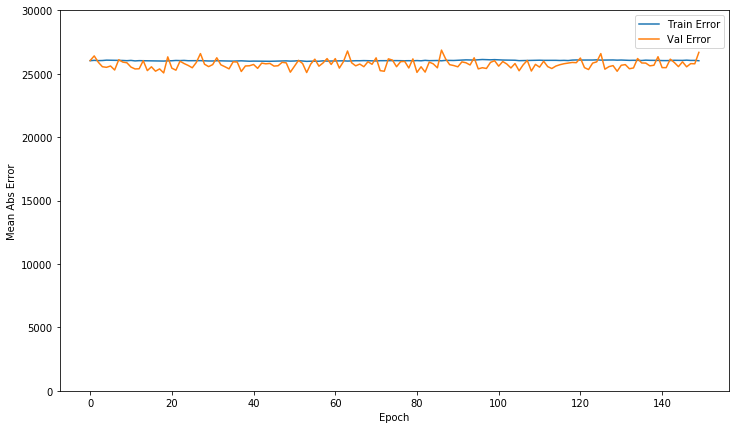

In [122]:
# It looks like with our model is senseless to train it with more epochs more due to val_loss does not seems to decrease
# and only training error is slightly decreising
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize = (12,7))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,30000])
  plt.legend(loc = 'best')



plot_history(history)

In [0]:
# predicting X_test and creating the frame containing true values and respective predictions of the model
predictions = model.predict(X_test)
True_pred= pd.concat([pd.DataFrame(y_test) , pd.DataFrame(predictions)], axis = 1)

In [124]:
y_test

array([ 6.33e+04,  6.21e+04,  5.52e+03, ..., -1.00e+00, -1.00e+00,
       -1.00e+00])

In [125]:
# The frame with true values and predicted values
True_pred.columns = ['true', 'pred'] 
True_pred.head()

true          pred
0  63300.0  12307.511719
1  62100.0  35181.226562
2   5520.0  33846.085938
3  66900.0  45166.859375
4  63660.0  43208.996094

In [126]:
# Adding residuals to the frame
True_pred['residuals']  = True_pred['true'] - True_pred['pred']
True_pred.head()

true          pred     residuals
0  63300.0  12307.511719  50992.488281
1  62100.0  35181.226562  26918.773438
2   5520.0  33846.085938 -28326.085938
3  66900.0  45166.859375  21733.140625
4  63660.0  43208.996094  20451.003906

In [127]:
print('The biigest error which can occur according to the model is:', np.round(True_pred['residuals'].min(), 2), 'or', np.round(True_pred['residuals'].max(), 2), 'seconds')
print('which is:', np.round((True_pred['residuals'].min()/60/60), 2), 'or', np.round((True_pred['residuals'].max()/60/60), 2), 'hrs')


The biigest error which can occur according to the model is: -962430.75 or 103923.0 seconds
which is: -267.34 or 28.87 hrs


In [128]:
print("On average the prediction error of the model is: {:5.2f} ± {:0.2f} sec".format(mae, True_pred['residuals'].std()))

On average the prediction error of the model is: 26857.07 ± 29007.26 sec


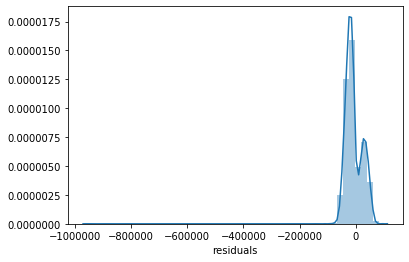

In [130]:
# The distribution of the residuals is very left skew
# So there are some errors with "-" time model can commit
# but the probability to commit this error is very very low
sns.distplot(True_pred['residuals'],bins=50);

In [131]:
# This is the sample from our data that is going to be predicted
sample = pd.DataFrame(sc.inverse_transform(X[50:55,:]), columns=X_.keys())
sample

Quantity   UnitPrice  Country_cat  ...         3         4         6
0   951.638116  125.519424     1.193734  ...  0.190522  0.151484  0.120294
1  1265.299055  102.558628     1.193734  ...  0.190522  0.151484  0.120294
2   951.638116  181.486367     1.193734  ...  0.190522  0.151484  0.120294
3   951.638116   41.927773     1.193734  ...  0.190522  0.151484  0.120294
4   951.638116   41.927773     1.193734  ...  0.190522  0.151484  0.120294

[5 rows x 19 columns]

In [132]:
y_.iloc[50:55]

50    1800.0
51    1800.0
52    1800.0
53    1800.0
54    1800.0
Name: next_order, dtype: float64

In [133]:
# Predicting the sample
pred_sample = model.predict(X[50:55,:])
pred_sample = pd.DataFrame((pred_sample))
pred_sample.reset_index(drop = True)


0
0  31430.455078
1  32823.656250
2  26497.443359
3  20732.390625
4  29094.632812

In [0]:
true_sample = pd.DataFrame(y_[50:55])
true_sample.reset_index(drop = True, inplace=True)

In [135]:
sample_frame = pd.concat([true_sample, pred_sample], axis = 1)
sample_frame.columns = ['true', 'pred']
sample_frame


true          pred
0  1800.0  31430.455078
1  1800.0  32823.656250
2  1800.0  26497.443359
3  1800.0  20732.390625
4  1800.0  29094.632812

# LSTM


In [0]:
# As the model does not seems to perform best on the given data I decided to build another one, this time RNN model and see if can do it better

In [0]:
# To prevent gradient exploding or vanishing I will use LSTM layers

model2 = tf.keras.Sequential()
# Creating LSTM unit with Dropout regularization just in case of overfitting
model2.add(tf.keras.layers.LSTM(units = 32 ,return_sequences=True, input_shape=(X_train.shape[1], 1)))
model2.add(tf.keras.layers.Dropout(rate=0.2))
# The same second layer
model2.add(tf.keras.layers.LSTM(units = 32 ,return_sequences=True, ))
model2.add(tf.keras.layers.Dropout(rate=0.2))

model2.add(tf.keras.layers.Dense(units=1))
model2.compile(optimizer = tf.keras.optimizers.RMSprop(0.01), loss='mae', metrics=['mae', 'mse'])

In [97]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 19, 32)            4352      
_________________________________________________________________
dropout_5 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 19, 32)            8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 19, 1)             33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train = X_train.reshape(371898, 19, 1)

In [98]:
history2 = model2.fit(
  X_train, y_train,
  epochs=20, validation_split = 0.3, verbose=2)

Train on 260328 samples, validate on 111570 samples
Epoch 1/20
260328/260328 - 161s - loss: 30561.8582 - mae: 30561.8887 - mse: 2027817856.0000 - val_loss: 28781.6755 - val_mae: 28781.6660 - val_mse: 1892814080.0000
Epoch 2/20
260328/260328 - 156s - loss: 29062.9453 - mae: 29062.9395 - mse: 1879570816.0000 - val_loss: 27678.9921 - val_mae: 27678.9922 - val_mse: 1759135488.0000
Epoch 3/20
260328/260328 - 156s - loss: 28191.1017 - mae: 28191.0449 - mse: 1753809024.0000 - val_loss: 27135.3478 - val_mae: 27135.3203 - val_mse: 1650466432.0000
Epoch 4/20
260328/260328 - 155s - loss: 27760.0452 - mae: 27760.0410 - mse: 1657360896.0000 - val_loss: 26932.3203 - val_mae: 26932.3027 - val_mse: 1573219712.0000
Epoch 5/20
260328/260328 - 156s - loss: 27595.0682 - mae: 27595.0312 - mse: 1594243584.0000 - val_loss: 26884.5009 - val_mae: 26884.4980 - val_mse: 1528658560.0000
Epoch 6/20
260328/260328 - 154s - loss: 27544.1356 - mae: 27544.0859 - mse: 1559836544.0000 - val_loss: 26880.5241 - val_mae: 26

In [99]:
# RNN model evaluation:
loss, mae, mse = model.evaluate(X_train, y_train, verbose=2)

print("Test set Mean Abs Error: {:5.2f} sec".format(mae))


371898/1 - 56s - loss: 36869.4246 - mae: 27320.7227 - mse: 1505026816.0000
Test set Mean Abs Error: 27320.72 sec


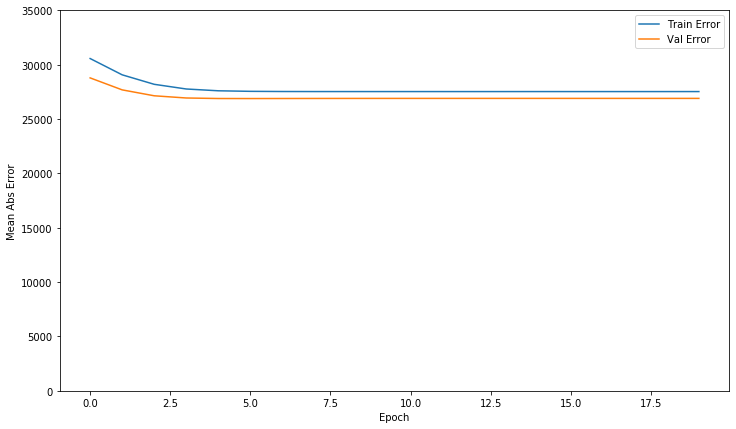

In [100]:
# The RNN model seems to work similar on this data
# Loss decreses during 6 epochs and then seems to stack in minimum of the loss function, only training loss is decreasing almost after each epoch

hist2 = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch
plt.figure(figsize = (12,7))
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(hist2['epoch'], hist2['mae'],
           label='Train Error')
plt.plot(hist2['epoch'], hist2['val_mae'],
           label = 'Val Error')
plt.ylim([0,35000])
plt.legend(loc = 'best')
 

In [102]:
model2.save('C:\\Users\\v-paszaf\\Downloads')
# new_model2 = keras.models.load_model('my_path.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\v-paszaf\Downloads/assets


In [176]:
print('The average error which can occur according to the RNN model is:', np.round(mae, 2), 'or', np.round(mae, 2), 'seconds')
print('which is:', np.round(mae/60/60, 2), 'hrs')


The average error which can occur according to the RNN model is: 27320.72 or 27320.72 seconds
which is: 7.59 hrs
